<a href="https://colab.research.google.com/github/stanlee321/unitary-matrix-text-classification/blob/master/QuantumUnitaryMatrixRepresentation_AmazonReviewPolarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unitary Text Classification



## 1. Introduction

This notebook describes how to train a simple 1 layer neural network to classify text in two categories, multi class classification is still in research and develop.
The novel part here is the input data for the neural network, combining the theory around random unitary matrices in qunatum mechanics, we where able to represent the text corpus in a feature vectors in every iteration of the learning process, this features vectors contains all the information from the text corpus input so the Neural Network can learn from this representation more fast and quikly. We test this approach with the AGNews dataset and obtain state of the art results in a few epochs.
This notebook uses the same functions as the AGNews test case with the difference that here we are using the AmazonReviewPolarity dataset which is more diverse, large and complex for test this new procedure.

### 1.1 Methodology

We are using a NxN unitary matrix representation for every word in our corpus, this is the major contrast with the traditional tokenizacion process that assings a single number as a token to a word in our dictionary of words.
This NxN unitary matrix is contructed based on the Haar measure,  according to https://pennylane.ai/qml/demos/tutorial_haar_measure.html . We are using the the random unitary group generated from scipy.stats that follows the haar measure.

Once we have a way to generate a trully random unitary matrix, we proceed to tokenize the words in our our corpus dictionary with one of this random unitary matrices. The procedure of how to do it is described below in the code.

Once we tokenize our words in our dataset, we proceed to use to calculate the Canonical Coset decomposition of our sequence of matrices to obtain our feature representation for a given sequence of texts, the procedure for do that is:

*  create function for create the composite matrix ( Linear Algebra and Cannonical Coset thoery)
*  we multiply the sequence of matrices (dot product)
* and we obtain a final composite matrix ( feature representation for a given piease of text)


The procees of create the cannonical representation is based on some hyperparameters like epsilon which control the importance of the most rare or common words in our dataset.

Once we generate our features table, we feed it this NxNxBatchSize vector to our neural network or Random Forest or XGBost algorithm, since this vector contains all the informacion for a given sequence of text

### 1.2 Intuition

The intuition begind this approach is as follows:


**Generate a NxN random unitary matrix**

In [65]:
from scipy.stats import unitary_group
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd

In [12]:
# Size of the  Random Unitary Matrix
N = 4

# Random Unitary Matrix
W = unitary_group.rvs(N)

print(W)
print(W.shape)

[[-0.29451007-0.13368404j  0.35136991+0.01513282j  0.76413021+0.34520029j
  -0.24968574+0.07938127j]
 [ 0.10593126+0.64527815j  0.54463965+0.12525103j -0.02026642+0.18488991j
   0.46099281-0.1138645j ]
 [ 0.20644072+0.43518298j -0.00778737-0.23111007j -0.1963265 +0.26422397j
  -0.56755934+0.53295731j]
 [-0.11215581-0.47244697j  0.64832523-0.30031967j -0.38476572-0.07709551j
   0.09137862+0.30225652j]]
(4, 4)


**Householder decomposition**

In linear algebra, a Householder transformation (also known as a Householder reflection or elementary reflector) is a linear transformation that describes a reflection about a plane or hyperplane containing the origin. (Wikipedia)

In [6]:
# Householder decomposition definition

def HouseholderLeftDecomposition(W):
    """
    This fransform a given W matrix into a set of cannonical coset factors.

    Params:
        W: NxN Random Unitary Matrix
    Returns:
        factors_list: list of NxN unitary matrices , Householder factors.
    """
    H = W.copy()  
    n = H.shape[0]

    ee = np.identity(n)

    factor_list = []

    for i in range(H.shape[0]-1):

        col = H[:,i]
        phase = np.angle(col[i])
        u = np.array([col + np.exp(1j*phase)*ee[i] ])
        uu = u.conj().T.dot(u)
        Q = (ee - 2*uu/np.real(np.trace(uu))).T
        H = Q.dot(H)
        factor_list.append(Q)

    factor_list.append(H)

    return factor_list

In [13]:
H_factors = HouseholderLeftDecomposition(W)

print(H_factors)

print(len(H_factors))

[array([[-0.32343099+0.j        ,  0.36317242-0.54379327j,
         0.36785557-0.31094095j, -0.2974039 +0.3838437j ],
       [ 0.36317242+0.54379327j,  0.67689639+0.j        ,
        -0.22871052-0.06582301j,  0.23933285+0.01686887j],
       [ 0.36785557+0.31094095j, -0.22871052+0.06582301j,
         0.82469657+0.j        ,  0.17284952-0.03681642j],
       [-0.2974039 -0.3838437j ,  0.23933285-0.01686887j,
         0.17284952+0.03681642j,  0.82183803+0.j        ]]), array([[ 1.00000000e+00+0.00000000e+00j,  8.92029472e-17-3.84693505e-17j,
         4.95799143e-18+8.29079256e-18j,  3.29539250e-17+2.32976563e-17j],
       [ 8.92029472e-17+3.84693505e-17j, -6.91362536e-01+0.00000000e+00j,
        -2.21031890e-02-1.66732510e-01j, -3.66219194e-01-5.99677468e-01j],
       [ 4.95799143e-18-8.29079256e-18j, -2.21031890e-02+1.66732510e-01j,
         9.83274857e-01+0.00000000e+00j, -6.39013452e-02+2.82647037e-02j],
       [ 3.29539250e-17-2.32976563e-17j, -3.66219194e-01+5.99677468e-01j,
        

In [14]:
## According to Theory , this must be zero

np.round( W - H_factors[0]@H_factors[1]@H_factors[2]@H_factors[3], decimals=9)

array([[ 0.+0.j,  0.-0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j],
       [-0.-0.j, -0.-0.j, -0.+0.j,  0.-0.j],
       [ 0.+0.j,  0.+0.j, -0.+0.j, -0.-0.j]])

Se we where able to decompose the matrix W into a set of matrices, this procedure is called Cannonical Coset Decomposition.

### 1.3 Canonical Coset Decomposition
A unitary matrix W can be decomposed in terms of a diagonal unitary group and a sequence of coset matrices.

* https://arxiv.org/pdf/1008.2477.pdf

* https://arxiv.org/pdf/0910.2910.pdf

* Gilmore, Robert. Lie groups, Lie algebras, and some of their applications. Courier Corporation, 2012.

In [16]:
# CanonicalCosetLeftDecomposition definition

def CanonicalCosetLeftDecomposition(W):
    """
    This calculates the Canonical Coset Decompostion for a given
    NxN random unitary matrix W

    Params:

        W: NxN Random Unitary Matrix

    Returns:
        factors: a list for the cannoical coset factors calculated for W
    """
    
    def ReflectionMatrix(n,i):
        """
        This reflect a matrix for given i around the Identity
        """
        if i < n-1:
            r = np.identity(n)
            r[i,i] = -1
            return r
        elif i == n-1:
            r = -np.identity(n)
            r[i,i] = 1
            return r
    
    n = W.shape[0]
    
    factors = HouseholderLeftDecomposition(W)
    
    factors = [ F@ReflectionMatrix(n,i) for i,F in enumerate(factors) ]
    
    return factors


In [17]:
CC_factors = CanonicalCosetLeftDecomposition(W)

The product of the sequence of canonical cosets is the original matrix

$W = C^{(3)} C^{(2)} C^{(1)} D $

In [18]:
np.round( W - CC_factors[0]@CC_factors[1]@CC_factors[2]@CC_factors[3]  ,decimals=9)

array([[ 0.-0.j,  0.-0.j,  0.+0.j, -0.-0.j],
       [ 0.+0.j,  0.-0.j,  0.-0.j, -0.+0.j],
       [-0.+0.j, -0.-0.j, -0.+0.j,  0.-0.j],
       [-0.+0.j,  0.+0.j, -0.-0.j,  0.+0.j]])

**Taking the Factor 3 (index 0 in list)**

Each canonical coset is unitary. For example

In [23]:
np.round( CC_factors[0]@CC_factors[0].T.conj() , decimals=12)

array([[ 1.+0.j, -0.+0.j, -0.+0.j,  0.-0.j],
       [-0.-0.j,  1.+0.j,  0.+0.j,  0.-0.j],
       [-0.-0.j,  0.-0.j,  1.+0.j, -0.+0.j],
       [ 0.+0.j,  0.+0.j, -0.-0.j,  1.+0.j]])

Each canonical coset has determinant 1 (No odd reflections included)

In [24]:
np.round( np.linalg.det( CC_factors[0] )  ,decimals=12)

(1+0j)

In [27]:
np.abs(CC_factors[0])

array([[0.32343099, 0.65391538, 0.48166586, 0.48557705],
       [0.65391538, 0.67689639, 0.23799406, 0.2399266 ],
       [0.48166586, 0.23799406, 0.82469657, 0.17672692],
       [0.48557705, 0.2399266 , 0.17672692, 0.82183803]])

([<matplotlib.axis.YTick at 0x7f9fd1399950>,
 <a list of 4 Text major ticklabel objects>)

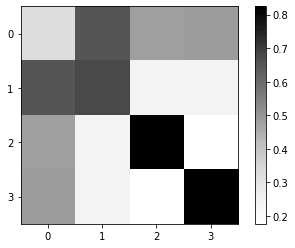

In [26]:
plt.imshow( np.abs(CC_factors[0]) ,cmap='Greys')
plt.colorbar()
plt.yticks( range(4) )

The third canonical coset is $C^{(3)}$:

In [31]:
CC_factors[0]

array([[ 0.32343099+0.j        ,  0.36317242-0.54379327j,
         0.36785557-0.31094095j, -0.2974039 +0.3838437j ],
       [-0.36317242-0.54379327j,  0.67689639+0.j        ,
        -0.22871052-0.06582301j,  0.23933285+0.01686887j],
       [-0.36785557-0.31094095j, -0.22871052+0.06582301j,
         0.82469657+0.j        ,  0.17284952-0.03681642j],
       [ 0.2974039 +0.3838437j ,  0.23933285-0.01686887j,
         0.17284952+0.03681642j,  0.82183803+0.j        ]])

In [29]:
# Show as table this C3 matrix
pd.DataFrame( np.round(CC_factors[0], decimals=5) )

,0,1,2,3
0,0.323430+0.000000j,0.363170-0.543790j,0.367860-0.310940j,-0.297400+0.383840j
1,-0.363170-0.543790j,0.676900+0.000000j,-0.228710-0.065820j,0.239330+0.016870j
2,-0.367860-0.310940j,-0.228710+0.065820j,0.824700+0.000000j,0.172850-0.036820j
3,0.297400+0.383840j,0.239330-0.016870j,0.172850+0.036820j,0.821840+0.000000j


This whole canonical coset $C^{(3)}$ can be fully reproduced by the following components of the first row
$ \vec{X}_{01} = C^{(3)}_{ 0,1:4  }$

In [30]:
X_01 = np.array([CC_factors[0][0,1:]])

pd.DataFrame(X_01)

,0,1,2
0,0.363172-0.543793j,0.367856-0.310941j,-0.297404+0.383844j


which is the same as the following components of the first column $ \vec{X}_{10}^{\dagger} =  C^{(3)}_{ 1:4,0  }$

In [33]:
X_10 = -np.array([ [x.conj()] for x in CC_factors[0][1:,0]])
pd.DataFrame(X_10)

,0
0,0.363172-0.543793j
1,0.367856-0.310941j
2,-0.297404+0.383844j


which can be confirmed as

In [34]:
(X_01) - (X_10).T

array([[0.+0.j, 0.+0.j, 0.+0.j]])

The first row of the first column of the canonical $C^{(3)}_{00}$ is a scalar number and reproduced as 
$\sqrt{1- X_{01}X_{01}^{\dagger} }$

In [35]:
X_00 = np.sqrt( 1-np.real(X_01@X_01.conj().T)  )

X_00

array([[0.32343099]])

The lower block diagonal of the canonical coset $C^{(3)}_{1:4,1:4}$ is reproduced as

In [38]:
X_11 = linalg.sqrtm( np.eye(3) - X_01.conj().T@X_01 )

In [39]:
pd.DataFrame(X_11)

,0,1,2
0,0.676896-0.000000j,-0.228711-0.065823j,0.239333+0.016869j
1,-0.228711+0.065823j,0.824697+0.000000j,0.172850-0.036816j
2,0.239333-0.016869j,0.172850+0.036816j,0.821838+0.000000j


Therefore, all the independent components are absorbed by the complex vector $\vec{X}_{01}$.

Moreover the canonical coset is unitary as long as $|X_{01}X_{01}^{\dagger}| \le 0$.

In fact each proper canonical coset is a topological ball. For this particular case, the ball is inscribed in a
6D space.

In summary, the canonical coset $C^{(0)}$ can be reconstructed as 

In [40]:
pd.DataFrame( 
    np.block( [[X_00 ,        X_01],
           [-X_10.conj(), X_11]] )
)

,0,1,2,3
0,0.323431+0.000000j,0.363172-0.543793j,0.367856-0.310941j,-0.297404+0.383844j
1,-0.363172-0.543793j,0.676896-0.000000j,-0.228711-0.065823j,0.239333+0.016869j
2,-0.367856-0.310941j,-0.228711+0.065823j,0.824697+0.000000j,0.172850-0.036816j
3,0.297404+0.383844j,0.239333-0.016869j,0.172850+0.036816j,0.821838+0.000000j


which can be definitely confirmed as

In [41]:
np.round(
    CC_factors[0] - np.block( [[X_00, X_01], [-X_01.T.conj(), X_11]] )
        ,decimals=12)

array([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -0.-0.j],
       [ 0.+0.j, -0.+0.j,  0.+0.j,  0.-0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]])

In summary, the leftmost canonical coset is the following block matrix:

$ Coset(X) =  \begin{pmatrix} 
    \sqrt{1 - X X^{\dagger}} & X \\
     -X^{\dagger}  & \sqrt{ \mathbf{1} - X^{\dagger} X  }
   \end{pmatrix}$

where $ X X^{\dagger} \le 1 $.

The implementation of this canonical coset matrix is

In [43]:

def CanonicalCosetBase(X_01):
    """
    Constructs a canonical coset matrix from the row vector X_01
    """
    m = len(X_01) 
    X_01 = np.array([X_01])
    X_00 = np.sqrt( 1-np.real(X_01@X_01.conj().T)  )
    X_11 = linalg.sqrtm( np.eye(m) - X_01.conj().T@X_01 )
    
    return np.block( [ [ X_00          , X_01],
                       [-X_01.T.conj() , X_11]] ) 

def CanonicalCoset(X,n):
    """
    Constructs a canonical coset matrix from the row vector X_01 embedded in a matrix space nxn
    """
    m = len(X)
    
    if m==n-1:
        return CanonicalCosetBase(X)
    
    identity = np.eye(n-m-1)
    
    zero = [0]*(len(X)+1)
    zero = np.array([ zero for _ in range(len(identity))])    
    
    #return CanonicalCosetBase(X) 
    
    return np.block([ [identity,zero],
                      [zero.T, CanonicalCosetBase(X) ] ])

In [44]:
CanonicalCoset( X_01[0], 4 ) 

array([[ 0.32343099+0.00000000e+00j,  0.36317242-5.43793270e-01j,
         0.36785557-3.10940952e-01j, -0.2974039 +3.83843704e-01j],
       [-0.36317242-5.43793270e-01j,  0.67689639-3.70276390e-18j,
        -0.22871052-6.58230064e-02j,  0.23933285+1.68688744e-02j],
       [-0.36785557-3.10940952e-01j, -0.22871052+6.58230064e-02j,
         0.82469657+0.00000000e+00j,  0.17284952-3.68164224e-02j],
       [ 0.2974039 +3.83843704e-01j,  0.23933285-1.68688744e-02j,
         0.17284952+3.68164224e-02j,  0.82183803+0.00000000e+00j]])

which provides with the correct values

In [45]:
np.round( CanonicalCoset( X_01[0], 4 ) - CC_factors[0] )

array([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -0.-0.j, -0.-0.j,  0.+0.j],
       [ 0.+0.j,  0.-0.j,  0.+0.j, -0.+0.j],
       [ 0.+0.j,  0.-0.j, -0.-0.j, -0.+0.j]])

**Taking the Factor 2 (index 1 in list)**

The second canonical coset $C^{(2)}$ is a lower block diagonal of size $3\times 3$


In [48]:
pd.DataFrame( np.round(CC_factors[1],decimals=5) )

,0,1,2,3
0,1.000000+0.000000j,-0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
1,0.000000+0.000000j,0.691360+0.000000j,-0.022100-0.166730j,-0.366220-0.599680j
2,0.000000-0.000000j,0.022100-0.166730j,0.983270+0.000000j,-0.063900+0.028260j
3,0.000000-0.000000j,0.366220-0.599680j,-0.063900-0.028260j,0.708090+0.000000j


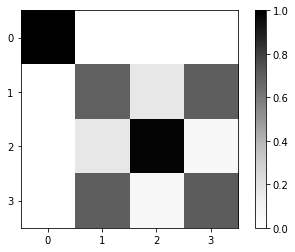

In [49]:
plt.imshow( np.abs(CC_factors[1]) ,cmap='Greys')
plt.colorbar()
plt.yticks( range(4) );

**Taking the Factor 1 (index *0* in list)**

The first canonical coset $C^{(1)}$ is a lower block diagonal of size $2 \times 2$

In [51]:
pd.DataFrame( np.round(CC_factors[2],decimals=5) )

,0,1,2,3
0,1.000000+0.000000j,0.000000-0.000000j,-0.000000+0.000000j,-0.000000-0.000000j
1,0.000000+0.000000j,1.000000+0.000000j,0.000000+0.000000j,-0.000000+0.000000j
2,0.000000+0.000000j,-0.000000+0.000000j,0.550820+0.000000j,0.322740+0.769700j
3,-0.000000+0.000000j,-0.000000-0.000000j,-0.322740+0.769700j,0.550820+0.000000j


([<matplotlib.axis.YTick at 0x7f9fd14454d0>,
 <a list of 4 Text major ticklabel objects>)

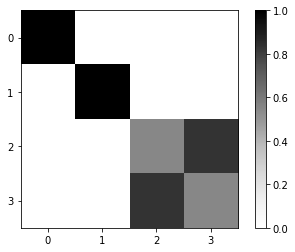

In [50]:
plt.imshow( np.abs(CC_factors[2]) , cmap='Greys')
plt.colorbar()
plt.yticks( range(4) )

**Taking the Factor 0: Diagonal Phases (index 3 in list)**




The last factor is not a coset but a diagonal unitary matrix that serves as a baseline subgroup. This last factor
is a n-dimensional torus.

In [53]:
pd.DataFrame( np.round(CC_factors[3],decimals=5) )

,0,1,2,3
0,-0.910580-0.413330j,0.000000-0.000000j,-0.000000-0.000000j,-0.000000+0.000000j
1,-0.000000-0.000000j,0.918250+0.396000j,-0.000000+0.000000j,0.000000-0.000000j
2,-0.000000-0.000000j,-0.000000+0.000000j,-0.225440+0.974260j,-0.000000+0.000000j
3,0.000000-0.000000j,0.000000-0.000000j,-0.000000-0.000000j,0.293410+0.955990j


([<matplotlib.axis.YTick at 0x7f9fd0c85a10>,
 <a list of 4 Text major ticklabel objects>)

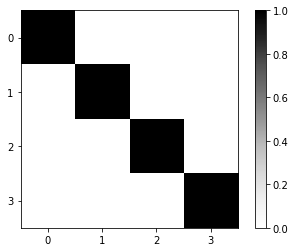

In [52]:
plt.imshow( np.abs(CC_factors[3]) ,cmap='Greys')
plt.colorbar()
plt.yticks( range(4) )

Each element of this diagonal unitary matrix has magnitude 1

In [54]:
np.round( np.abs(CC_factors[3]) ,decimals=12)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

Therefore the independent parameters of the unitary matrix are the phases only.


The following function collects the values of the independent values of all the cosets and the phases

In [59]:
# The trick is to extract the independent parameters from each Householder matrix

def CanonicalCosetPosition(C,i):
    n = C.shape[0]
    if i < n-1:
        return C[i,i+1:]
    elif i == n-1:
        return np.diag(C)


def CanonicalCosetLeftDecompositionParametersComplex(W):

    factors = CanonicalCosetLeftDecomposition(W)
    
    positions = [ CanonicalCosetPosition(f,i) for i,f in enumerate(factors) ]
    
    return positions

def CanonicalCosetLeftDecompositionParametersReal(W):
    
    def CanonicalCosetPosition(C,i):
        n = C.shape[0]
        if i<n-1:
            return C[i,i+1:]
        elif i == n-1:
            return np.diag(C)
    
    n = W.shape[0]
    
    factors = CanonicalCosetLeftDecomposition(W)
    
    positions = np.concatenate(
        [ CanonicalCosetPosition(f,i) for i,f in enumerate(factors) if i<n-1 ])
    
    # positions = np.concatenate([ np.real(positions) , np.imag(positions) ])
    # phases = np.real(np.angle( np.diag(factors[n-1]) ))

    positions = np.array([ (np.real(x),np.imag(x)) for x in positions  ]).flatten()
    phases = np.real(np.angle( np.diag(factors[n-1]) ))
    
    
    return  np.concatenate( [positions,phases] )

In [56]:
# Real numbers case

CanonicalCosetLeftDecompositionParametersReal(W)

array([ 0.36317242, -0.54379327,  0.36785557, -0.31094095, -0.2974039 ,
        0.3838437 , -0.02210319, -0.16673251, -0.36621919, -0.59967747,
        0.32274267,  0.7696977 , -2.71548356,  0.407158  ,  1.79818733,
        1.27300186])

In [60]:
# Complex numbers case

CanonicalCosetLeftDecompositionParametersComplex(W)

[array([ 0.36317242-0.54379327j,  0.36785557-0.31094095j,
        -0.2974039 +0.3838437j ]),
 array([-0.02210319-0.16673251j, -0.36621919-0.59967747j]),
 array([0.32274267+0.7696977j]),
 array([-0.91058087-0.41333096j,  0.91824997+0.39600126j,
        -0.22543646+0.97425787j,  0.29341246+0.95598595j])]

For example, the initial 4 elements are

In [61]:
-X_01

array([[-0.36317242+0.54379327j, -0.36785557+0.31094095j,
         0.2974039 -0.3838437j ]])

Another method to get the parametrization is

In [63]:
def CanonicalCosetLeftDecompositionParameters(W):
    
    def CanonicalCosetPosition(C,i):
        n = C.shape[0]
        if i<n-1:
            return C[i,i+1:]
        elif i == n-1:
            return np.diag(C)
    
    n = W.shape[0]
    
    factors = CanonicalCosetLeftDecomposition(W)
    
    positions = np.concatenate(
        [ CanonicalCosetPosition(f,i) for i,f in enumerate(factors) if i<n-1 ])
    
    #positions = np.concatenate([ np.real(positions) , np.imag(positions) ])
    positions = np.array([ (np.real(x),np.imag(x)) for x in positions  ]).flatten()
    
    phases = np.real(np.angle( np.diag(factors[n-1]) ))
    
    return  np.concatenate( [positions,phases] )
    
def CanonicalCosetLeftDecompositionParametersDict(W):
    params = CanonicalCosetLeftDecompositionParameters(W)
    
    n = len(W)
    labels = CanonicalCosetLabels(n)
    return dict(zip( labels , params ))

def LeftCanonicalCosetDimensions(n):
    return [ 2*(m-1) for m in range(n,1,-1) ]

def LeftCanonicalCosetPartition(n):
    full_range = list(range(n*n))
    
    subsets = []

    for k in LeftCanonicalCosetDimensions(n):
        subsets.append( full_range[0:k] )
        full_range = full_range[k:]
        
    subsets.append( list(range(n*n))[-n:] )        

    return subsets

def CanonicalCosetLabels(n):
    #CC_DIMS = [ 2*(m-1) for m in range(n,1,-1) ]
    CC_DIMS = LeftCanonicalCosetDimensions(n)
    
    CCosetLabels = [  ['CCoset_'+str(n-i-1)+'_'+str(j) for j in range(DIM)  ] for i, DIM in  enumerate(CC_DIMS) ]
    
    PHASES = [ 'CCoset_0_'+str(i) for i in range(n) ]
    
    LABELS = CCosetLabels + [PHASES]
    
    return list(itertools.chain(*LABELS)) 

In [66]:
CanonicalCosetLeftDecompositionParametersDict(W)

{'CCoset_0_0': -2.7154835555274133,
 'CCoset_0_1': 0.40715799899193467,
 'CCoset_0_2': 1.7981873307582097,
 'CCoset_0_3': 1.2730018613999838,
 'CCoset_1_0': 0.3227426736092458,
 'CCoset_1_1': 0.7696976983064675,
 'CCoset_2_0': -0.022103189014521116,
 'CCoset_2_1': -0.16673250954251093,
 'CCoset_2_2': -0.36621919430673855,
 'CCoset_2_3': -0.5996774678345932,
 'CCoset_3_0': 0.3631724196108625,
 'CCoset_3_1': -0.5437932699966099,
 'CCoset_3_2': 0.3678555726738901,
 'CCoset_3_3': -0.31094095225288193,
 'CCoset_3_4': -0.2974038975578652,
 'CCoset_3_5': 0.38384370406796164}

The utility function with the labels is

In [67]:
CanonicalCosetLabels(4)

['CCoset_3_0',
 'CCoset_3_1',
 'CCoset_3_2',
 'CCoset_3_3',
 'CCoset_3_4',
 'CCoset_3_5',
 'CCoset_2_0',
 'CCoset_2_1',
 'CCoset_2_2',
 'CCoset_2_3',
 'CCoset_1_0',
 'CCoset_1_1',
 'CCoset_0_0',
 'CCoset_0_1',
 'CCoset_0_2',
 'CCoset_0_3']

In [71]:
param_list = CanonicalCosetLeftDecompositionParameters(W)
param_list

array([ 0.36317242, -0.54379327,  0.36785557, -0.31094095, -0.2974039 ,
        0.3838437 , -0.02210319, -0.16673251, -0.36621919, -0.59967747,
        0.32274267,  0.7696977 , -2.71548356,  0.407158  ,  1.79818733,
        1.27300186])

In [72]:
param_list = CanonicalCosetLeftDecompositionParametersReal(W)
param_list

array([ 0.36317242, -0.54379327,  0.36785557, -0.31094095, -0.2974039 ,
        0.3838437 , -0.02210319, -0.16673251, -0.36621919, -0.59967747,
        0.32274267,  0.7696977 , -2.71548356,  0.407158  ,  1.79818733,
        1.27300186])

We can recover all the canonical cosets as

In [74]:
def ComplexifyEvenVector(V):
    n = len(V)
    if n%2 == 0:
        return [ x+1j*y for x,y in V.reshape(n//2,2)]
    else:
        print('ComplexifyVector::Error, odd vector dimension')
        return 0

In [75]:
CC_factor_3 = CanonicalCoset( ComplexifyEvenVector(param_list[0:6]) , 4 )

In [76]:
CC_factor_2 = CanonicalCoset( ComplexifyEvenVector(param_list[6:10]) , 4 )

In [77]:
CC_factor_1 = CanonicalCoset( ComplexifyEvenVector(param_list[10:12]), 4 )

In [78]:
CC_phases = np.diag(np.exp( 1j*param_list[12:16] ))

and multiply them together to obtain the original unitary matrix W

In [79]:
np.round( W - CC_factor_3@CC_factor_2@CC_factor_1@CC_phases )

array([[-0.-0.j, -0.-0.j,  0.+0.j, -0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.-0.j,  0.-0.j],
       [ 0.+0.j,  0.-0.j, -0.+0.j, -0.+0.j],
       [ 0.+0.j,  0.-0.j, -0.-0.j, -0.+0.j]])

This series of cosets can be used to construct subgroup structures

### 1.4 Random Cosets

Random phases can be used to construct the core diagonal subgroup

In [80]:
np.diag( np.exp( 2*1j*np.pi*np.random.random_sample(4) ) )

array([[ 0.91411265+0.40546031j,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        , -0.01610581-0.99987029j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.29944769+0.95411272j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , -0.08885179-0.99604486j]])

Random points in n-dimensional balls can be generated as

In [81]:
def RandomBall(dimension, num_points,  radius=1):
    # https://stackoverflow.com/questions/54544971
    #from numpy import random, linalg
    # First generate random directions by normalizing the length of a
    # vector of random-normal values (these distribute evenly on ball).
    random_directions = np.random.normal(size=(dimension,num_points))
    random_directions /= linalg.norm(random_directions, axis=0)
    # Second generate a random radius with probability proportional to
    # the surface area of a ball with a given radius.
    random_radii = np.random.random(num_points) ** (1/dimension)
    # Return the list of random (direction & length) points.
    return radius * (random_directions * random_radii).T

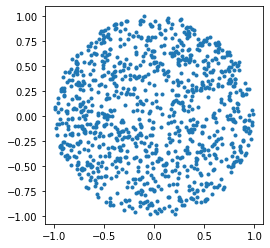

In [82]:
random_points = RandomBall(2,1000)

plt.plot( random_points[:,0], random_points[:,1]  ,'.')

plt.gca().set_aspect(1)

##### **bold text** Random Canonical Coset  $ C^{(1)} \approx 2D$

Random instances of the canonical coset from the generation of random points in a ball 2D

In [83]:
def FrobeniusDistance2( U1,U2 ):
    return np.real( np.trace(U1@U2.conj().T) )

In [84]:
n_samples = 200
random_CCoset_1_list = [ CanonicalCoset( ComplexifyEvenVector( ball_2d ), 4 ) 
                        for ball_2d in   RandomBall(2,n_samples) ]

pairwise distances among canonical cosets.

In [85]:
distance1_list = [ FrobeniusDistance2( random_CCoset_1_list[i], random_CCoset_1_list[j] ) 
 for i,j in   itertools.combinations( range(n_samples) ,2)   ] 

Text(0.5, 0, 'FrobeniusDistance square')

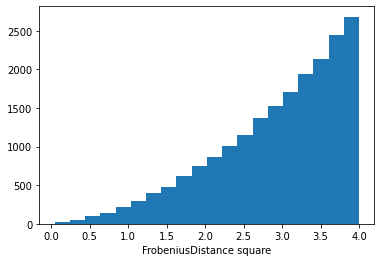

In [86]:
plt.hist( distance1_list ,bins=20);
plt.xlabel('FrobeniusDistance square')

##### Random Canonical Coset $ C^{(2)} \approx 4D$

In [87]:
n_samples = 200

random_CCoset_2_list = [ CanonicalCoset( ComplexifyEvenVector( ball_4d ), 4 ) 
                        for ball_4d in   RandomBall(4,n_samples) ]

In [88]:
distance2_list = [ FrobeniusDistance2( random_CCoset_2_list[i], random_CCoset_2_list[j] )  
 for i,j in   itertools.combinations( range(n_samples) ,2)   ] 

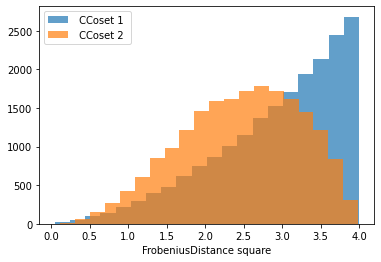

In [89]:
plt.hist(distance1_list,bins=20, label=' CCoset 1 ', alpha=0.7);
plt.hist(distance2_list,bins=20, label=' CCoset 2 ', alpha=0.7);
plt.legend()
plt.xlabel('FrobeniusDistance square');

##### Random Canonical Coset $ C^{(3)} \approx 6D$

In [90]:
n_samples = 200

random_CCoset_3_list = [ CanonicalCoset( ComplexifyEvenVector( ball_6d ), 4 ) 
                        for ball_6d in   RandomBall(6,n_samples) ]

In [91]:
distance3_list = [ FrobeniusDistance2( random_CCoset_3_list[i], random_CCoset_3_list[j] )  
 for i,j in   itertools.combinations( range(n_samples) ,2)   ] 

Text(0.5, 0, 'FrobeniusDistance square')

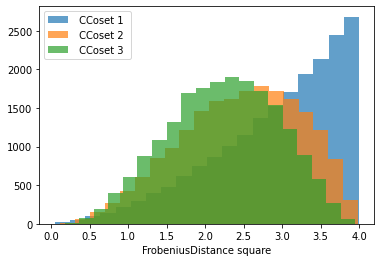

In [92]:
plt.hist(distance1_list,bins=20, label=' CCoset 1 ', alpha=0.7);
plt.hist(distance2_list,bins=20, label=' CCoset 2 ', alpha=0.7);
plt.hist(distance3_list,bins=20, label=' CCoset 3 ', alpha=0.7);

plt.legend()
plt.xlabel('FrobeniusDistance square')

##### Distance among different cosets

In [93]:
distance_12_list = [ FrobeniusDistance2( random_CCoset_1_list[i], random_CCoset_2_list[j] )  
 for i,j in   itertools.combinations( range(n_samples) ,2)   ] 

distance_13_list = [ FrobeniusDistance2( random_CCoset_1_list[i], random_CCoset_3_list[j] )  
 for i,j in   itertools.combinations( range(n_samples) ,2)   ] 

Text(0.5, 0, 'FrobeniusDistance square')

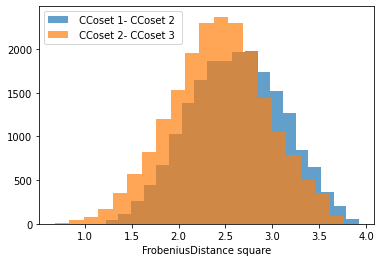

In [94]:
plt.hist( distance_12_list, bins=20, label=' CCoset 1- CCoset 2 ', alpha=0.7);
plt.hist( distance_13_list,  bins=20, label=' CCoset 2- CCoset 3 ', alpha=0.7);

plt.legend()
plt.xlabel('FrobeniusDistance square')

##### Grid

The grid of unitary matrices around the identity is

In [97]:
def flatten_list(L):
    return list( itertools.chain.from_iterable( L ) )

def GridPhases(matrix_dim, n):
    
    phi_grid = np.linspace(-np.pi,np.pi,n+1)[0:-1]
    phi_grid = range(n)
    
    mesh = np.meshgrid( *([phi_grid]*matrix_dim) ,sparse=False, indexing='ij' )
    mesh = [ axis.flatten() for axis in mesh]

    mesh = np.array(mesh).T
    
    return list(map( lambda x: np.diag(x), np.exp(1j*mesh) ))


def Grid_dU_Diagonal(n,epsilon):
    axis0 = np.array([epsilon]+[0]*(n-1))
    
    return [ np.diag( np.exp(1j*epsilon*np.roll(axis0,n)) ) for n in range(n) ]
    

def Grid_dU_CanonicalCoset( n, m ,epsilon ):
    """
    Left Canonical Coset m, for nxn unitary matrices 
    """
    axis0 = np.array([epsilon]+[0]*(m-1))
    
    axis_list = np.array([ np.roll(axis0,k) for k in range(m) ] )
    
    pre = [  [ CanonicalCoset( epsilon*X , n ), CanonicalCoset( 1j*epsilon*X , n ) ] for X in axis_list ]
    
    return flatten_list(pre)


def Grid_dU(n, epsilon ):
    
    CCosets_list = [  Grid_dU_CanonicalCoset( n, m ,epsilon ) for m in  range( n-1, 0, -1 ) ]
    
    return flatten_list(CCosets_list) + Grid_dU_Diagonal(n,epsilon)

In [100]:
epsilon = 0.001

n = 4

grid = Grid_dU(n, epsilon)

print(len(grid))
grid[:5]

16


[array([[ 1.e+00,  1.e-06,  0.e+00,  0.e+00],
        [-1.e-06,  1.e+00,  0.e+00,  0.e+00],
        [-0.e+00,  0.e+00,  1.e+00,  0.e+00],
        [-0.e+00,  0.e+00,  0.e+00,  1.e+00]]),
 array([[ 1.+0.e+00j,  0.+1.e-06j,  0.+0.e+00j,  0.+0.e+00j],
        [-0.+1.e-06j,  1.+0.e+00j,  0.+0.e+00j,  0.+0.e+00j],
        [-0.+0.e+00j,  0.+0.e+00j,  1.+0.e+00j,  0.+0.e+00j],
        [-0.+0.e+00j,  0.+0.e+00j,  0.+0.e+00j,  1.+0.e+00j]]),
 array([[ 1.e+00,  0.e+00,  1.e-06,  0.e+00],
        [-0.e+00,  1.e+00,  0.e+00,  0.e+00],
        [-1.e-06,  0.e+00,  1.e+00,  0.e+00],
        [-0.e+00,  0.e+00,  0.e+00,  1.e+00]]),
 array([[ 1.+0.e+00j,  0.+0.e+00j,  0.+1.e-06j,  0.+0.e+00j],
        [-0.+0.e+00j,  1.+0.e+00j,  0.+0.e+00j,  0.+0.e+00j],
        [-0.+1.e-06j,  0.+0.e+00j,  1.+0.e+00j,  0.+0.e+00j],
        [-0.+0.e+00j,  0.+0.e+00j,  0.+0.e+00j,  1.+0.e+00j]]),
 array([[ 1.e+00,  0.e+00,  0.e+00,  1.e-06],
        [-0.e+00,  1.e+00,  0.e+00,  0.e+00],
        [-0.e+00,  0.e+00,  1.e+00, 

The number of unitary matrices is always $n^2$

In [101]:
len( Grid_dU(n,epsilon)  )

16

In [102]:
Grid_dU(n,epsilon)[0].dot(Grid_dU(n,epsilon)[0].T)

array([[ 1.00000000e+00, -8.32531743e-23,  0.00000000e+00,
         0.00000000e+00],
       [-8.32531743e-23,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [103]:
len( Grid_dU(5,epsilon)  )

25

For example, a matrix  20𝑥20  can accomodate 400 unitary matrices

In [104]:
20**2

400

## 2. Implementation



We use the functions and the theory above for the problem of text classification with two classes.

In [ ]:
# Some imports

from scipy.linalg import fractional_matrix_power as MatrixPow
from scipy.stats import unitary_group
import numpy as np
from scipy import linalg
import itertools


We define the same functions explored above and implement new ones.

In [ ]:
## Setup Custom functions

This functions is used for calculate some **epsilon** based of word frecuency. This default values where obtained by trial and error.

In [105]:
########################################
def calculate_epsilon_simple(count_dict,
                            word,
                            unk_e: float = 0.000001,
                            lf_e: float = 0.0001,
                            hf_e: float = 0.001,
                            lf_range: int = 0,
                            hf_range: int = 1250):
    """
    This functions is used for calculate some epsilon based on word frecuency.

    """
    try:
        count = count_dict[word]
    except:
        return unk_e, "unk"
    
    if lf_range <= count <= hf_range:
        return lf_e, "lf"
    return hf_e, "hf"



We create another aux function for assign to each word in our dictinoary a given value of epsilon.


In [ ]:

def create_unique_words_with_epsilon(
    vocav_frec,     # Vocab used
    unique_words,   # List of unique words
    lf_e: float=0.0001,
    hf_e: float=0.001,
    lf_range: int=0,
    hf_range: int=1250):
    """
    Assign to each word in our dict a given epsilon based on word frecuency.
    """

    w_e_pairs_list = []

    for w in tqdm(unique_words):

        e, kind_word = calculate_epsilon_simple(
                vocav_frec,
                w,
                lf_e = lf_e,
                hf_e = hf_e,
                lf_range = lf_range,
                hf_range = hf_range
        )
        w_e_pairs_list.append( (w, e, kind_word ) )

    return w_e_pairs_list

In [106]:

def RandomUnitaryBaseElement(n,epsilon):
    """
    Input:
        n: Matrix size
        epsilon: small mumber where zero limits to the identity matrix
    """
    return MatrixPow( unitary_group.rvs(n), epsilon )

def QuasiDiagonalBasisElement(n,epsilon, dtheta,i):
    """

    """

    diag1 = np.roll( np.append(np.ones(n-1), np.exp(1j*dtheta)) ,1)
    
    return np.diag(np.roll(diag1,i)).dot(RandomUnitaryBaseElement(n,epsilon)) 

In [ ]:

def flatten_list(L):
        return list( itertools.chain.from_iterable( L ) )

def Grid_dU_Diagonal(n,epsilon):
    axis0 = np.array([epsilon]+[0]*(n-1))
    
    return [ np.diag( np.exp(1j*epsilon*np.roll(axis0,n)) ) for n in range(n) ]


def CanonicalCosetBase(X_01):
    """
    Constructs a canonical coset matrix from the row vector X_01
    """
    m = len(X_01) 
    X_01 = np.array([X_01])
    X_00 = np.sqrt( 1-np.real(X_01@X_01.conj().T)  )
    X_11 = linalg.sqrtm( np.eye(m) - X_01.conj().T@X_01 )
    
    return np.block( [ [ X_00          , X_01],
                       [-X_01.T.conj() , X_11]] ) 

def CanonicalCoset(X,n):
    """
    Constructs a canonical coset matrix from the row vector X_01 embedded in a matrix space nxn
    """
    m = len(X)
    
    if m==n-1:
        return CanonicalCosetBase(X)
    
    identity = np.eye(n-m-1)
    
    zero = [0]*(len(X)+1)
    zero = np.array([ zero for _ in range(len(identity))])    
    
    #return CanonicalCosetBase(X) 
    
    return np.block([ [identity,zero],
                      [zero.T, CanonicalCosetBase(X) ] ])


def Grid_dU_CanonicalCoset( n, m ,epsilon ):
    """
    Left Canonical Coset m, for nxn unitary matrices 
    """
    axis0 = np.array([epsilon]+[0]*(m-1))
    
    axis_list = np.array([ np.roll(axis0,k) for k in range(m) ] )
    
    pre = [  [ CanonicalCoset( epsilon*X , n ), CanonicalCoset( 1j*epsilon*X , n ) ] for X in axis_list ]
    
    return flatten_list(pre)


def Grid_dU(n, epsilon ):
    
    CCosets_list = [  Grid_dU_CanonicalCoset( n, m ,epsilon ) for m in  range( n-1, 0, -1 ) ]
    
    return flatten_list(CCosets_list) + Grid_dU_Diagonal(n,epsilon)

In [ ]:
def Text_DiagonalBaseDict(n, w_e_pairs_list, dtheta, epsilon_grid):
    """
    This func samples random matrices around the diagonal from a queue,
    it used the word - epsilon  pairs for use a queue that holds
    the Grid's matrices, in each use of a pair with 'low frec' - lf,
    it samples some matrices from the grid until it remains empty.
    """

    # Create dequeue for elements in grid
    deq = collections.deque( Grid_dU(n, epsilon_grid) )

    basis = {}

    for i, (w, epsilon, kind) in enumerate(tqdm(w_e_pairs_list)):  
        if kind == "lf":
            if len(deq) > 0:
                basis[w] = deq.pop()
            else:
                basis[w] = QuasiDiagonalBasisElement(n,epsilon, dtheta,i)
        else:
            basis[w] = QuasiDiagonalBasisElement(n,epsilon,dtheta,i)
    
    return basis

In [ ]:
########################
# Householder decompositions
#########################

In [ ]:
def HouseholderLeftDecomposition(W):
    H = W.copy()  
    n = H.shape[0]

    ee = np.identity(n)

    factor_list = []

    for i in range(H.shape[0]-1):

        col = H[:,i]
        phase = np.angle(col[i])
        u = np.array([col + np.exp(1j*phase)*ee[i] ])
        uu = u.conj().T.dot(u)
        Q = (ee - 2*uu/np.real(np.trace(uu))).T
        H = Q.dot(H)
        factor_list.append(Q)

    factor_list.append(H)

    return factor_list

def CanonicalCosetLeftDecomposition(W):
    
    def ReflectionMatrix(n,i):
        if i < n-1:
            r = np.identity(n)
            r[i,i] = -1
            return r
        elif i == n-1:
            r = -np.identity(n)
            r[i,i] = 1
            return r
    
    n = W.shape[0]
    
    factors = HouseholderLeftDecomposition(W)
    
    factors = [ F@ReflectionMatrix(n,i) for i,F in enumerate(factors) ]
    
    return factors



# The trick is to extract the independent parameters from each Householder matrix

def CanonicalCosetPosition(C,i):
    n = C.shape[0]
    if i < n-1:
        return C[i,i+1:]
    elif i == n-1:
        return np.diag(C)


def CanonicalCosetLeftDecompositionParametersComplex(W):
    factors = CanonicalCosetLeftDecomposition(W)
    
    positions = [ CanonicalCosetPosition(f,i) for i,f in enumerate(factors) ]
    
    return positions

def CanonicalCosetLeftDecompositionParametersReal(W):
    
    def CanonicalCosetPosition(C,i):
        n = C.shape[0]
        if i<n-1:
            return C[i,i+1:]
        elif i == n-1:
            return np.diag(C)
    
    n = W.shape[0]
    
    factors = CanonicalCosetLeftDecomposition(W)
    
    positions = np.concatenate(
        [ CanonicalCosetPosition(f,i) for i,f in enumerate(factors) if i<n-1 ])
    
    # positions = np.concatenate([ np.real(positions) , np.imag(positions) ])
    # phases = np.real(np.angle( np.diag(factors[n-1]) ))

    positions = np.array([ (np.real(x),np.imag(x)) for x in positions  ]).flatten()
    phases = np.real(np.angle( np.diag(factors[n-1]) ))
    
    
    return  np.concatenate( [positions,phases] )


## create function for create the composite matrix
#  we multiply the sequence of matrices
# and we obtain a final composite matrix

def create_composite_matrix(text_to_matrix_dict:dict , input_tokens:list):

    M = text_to_matrix_dict[ input_tokens[0] ]

    for a in input_tokens:
        M = M.dot(text_to_matrix_dict[a])

    return M

def create_embeding_matrix(words_to_unitary_dict:dict, text_inputs:list ):
    """
    Creates the embeding representation for some list of texts inputs. 
        e.g. : text_inputs = ["this, "is", "one", "example"]
    """

    # Create composite matrix for token inputs 
    W = create_composite_matrix(words_to_unitary_dict, input_tokens = text_inputs)

    # Create embeding
    E = CanonicalCosetLeftDecompositionParametersReal(W)

    return E

## Text Classification Setup

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.data.utils import get_tokenizer

from torchtext.datasets import AmazonReviewPolarity

from torch.autograd import Function
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, datasets

torch.manual_seed(1)

In [ ]:
import collections
from collections import Counter

import nltk
from nltk.corpus import wordnet as wn

from tqdm import tqdm
import pandas as pd
import time

import matplotlib.pyplot as plt

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from torchtext.vocab import Vocab

tokenizer = get_tokenizer('basic_english')

# Load the dataset generators
train_iter, val_iter = AmazonReviewPolarity()


amazon_review_polarity_csv.tar.gz: 688MB [00:04, 169MB/s]


In [ ]:
# Create the Counter object that holds our
# word - count pairs that will be used 
# in the epsilon calculations 

labels = []
counter = Counter()
sizes = []

for (label, line) in train_iter:
    counter.update(tokenizer(line))
    labels.append(label)
    sizes.append(len(line))
    
for (label, line) in val_iter:
    counter.update(tokenizer(line))
    labels.append(label)



In [ ]:
# load again the dataset because of the generator used before

train_iter, val_iter = AmazonReviewPolarity()

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# Construct the vocab
vocab = build_vocab_from_iterator(yield_tokens(train_iter + val_iter), specials=["<unk>"])

vocab.set_default_index(vocab["<unk>"])


In [ ]:
# Get some constats.

VOCAB_SIZE = len(vocab)
print(VOCAB_SIZE)

UNIQUE_WORDS = vocab.get_itos()
FREC_DICT =  dict(counter)

1685001


In [ ]:
# Calculate the word - epsilon pairs.

w_e_pairs_simple = create_unique_words_with_epsilon(
        FREC_DICT,
        UNIQUE_WORDS,
        lf_e=0.0001,
        hf_e=0.001,
        lf_range=0,
        hf_range=825
    )

print(w_e_pairs_simple[:10])

100%|██████████| 1685001/1685001 [00:03<00:00, 478520.62it/s]

[('<unk>', 1e-06, 'unk'), ('.', 0.001, 'hf'), ('the', 0.001, 'hf'), (',', 0.001, 'hf'), ('i', 0.001, 'hf'), ('and', 0.001, 'hf'), ('a', 0.001, 'hf'), ('to', 0.001, 'hf'), ('it', 0.001, 'hf'), ('of', 0.001, 'hf')]


In [ ]:
# Count the high frec words and low frec words.

labels_tokens = [sample[2] for sample in w_e_pairs_simple ]

labels_tokens[:10]

c = Counter(labels_tokens)
c

Counter({'hf': 13289, 'lf': 1671711, 'unk': 1})

In [ ]:
# Assign a random unitary matrix to a given word (tokenization with matrix instead of a number).
# We feed the w_e_pairs and based on the word frecuency, we create a random
# unitary matrix for the given word w_

# Size of the unitary matrix
N = 5

# Thete is used as some hypter param in the Quasi Diagonal matrix creation process.
# this number works great in AGNews dataset
theta = 0.0001

# The epsilon that will be used in the Grids's matrices for low frec words samples.
# this will override the actual low frec words epsilon until the queue going to empty.
epsilon_grid = 0.001

# Token (word) to RandomUnitary NxN map
AA_dict = Text_DiagonalBaseDict( N, w_e_pairs_simple, theta, epsilon_grid )


100%|██████████| 1685001/1685001 [1:25:22<00:00, 328.97it/s]


Use some standar ML libraries for handle the dataset creation (new features vectors from the procedure)

In [ ]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns

tqdm.pandas()

In [ ]:
# Since the lables are  1 and 2
# we must to start the labels from 0 instead of 1.

label_pipeline = lambda x: int(x) - 1

# tokenization process for word to number
text_pipeline = lambda x: tokenizer(x)


def convert_text_to_features(AA_dict, text):
    """
    This functions resumes all the staps for create the vector features from the text input
    based on the new procedure.

    Inputs:
        AA_dict: dict that holds the map from Word to Random Unitary Matrix.

    """

    # create tokens from text input
    text_tokens = text_pipeline(text)

    # Create feature vector using the AA_dict map and the tokens
    embedding = create_embeding_matrix( words_to_unitary_dict = AA_dict, text_inputs = text_tokens  )

    # Create dict for the dataset pipeline
    sample = {"Text": np.float32(embedding), "Class": label}

    return sample


def create_features_label_df(input_dataframe, AA_dict:dict ):
    """
    This functions takes the original dataset dataframe and creates new columns
    that holds the vector representation called "features" for the column "text" 
    """
    
    _df = input_dataframe.copy()
    
    # Calculate embeeded representation for text
    _df["features"] = _df["Text"].progress_apply(
        lambda x: convert_text_to_features(AA_dict, x)["Text"])
    
    # Create features columns
    features = _df["features"].apply(pd.Series)
    features = features.rename(columns = lambda x : 'feature_' + str(x))
    new_df = pd.concat([_df[["Text","Class"]], features[:]], axis=1)

    return new_df

In [ ]:
# Show the size of the training set 36 Millions of samples.
len(train_iter)

3600000

In [ ]:
# Create dataset generators again.
train_iter, test_iter = AmazonReviewPolarity()

# Convert generators to list
train_dataset = list(train_iter)
test_dataset = list(test_iter)

# Split the dataset 
num_train = int(len(train_dataset) * 0.95)

# Create validation set
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])


# Create train, val, test sets
train_pairs = [{"Text": line, "Class": label} for (label, line) in split_train_]
valid_pairs = [{"Text": line, "Class": label} for (label, line) in split_valid_]
test_pairs  = [{"Text": line, "Class": label} for (label, line) in test_dataset]


# create Pandas DataFrame
text_labels_df_train = pd.DataFrame(train_pairs)
text_labels_df_valid = pd.DataFrame(valid_pairs)
text_labels_df_test = pd.DataFrame(test_pairs)

In [ ]:
# Show some part of the train set.
text_labels_df_train

,Text,Class
0,"POS The picture is a lie, the inside is cardbo...",1
1,very informative I was very impressed with the...,2
2,Don't waste your money Bad product. When I tri...,1
3,"One adjective: ADRENALINE-PUMPING !!! ""Say Any...",2
4,It's all you need I stated off with Casenote L...,2
...,...,...
3419995,why did i do it i thought it would be a combo ...,1
3419996,bring it on agian ...sucks I have one word for...,1
3419997,This came along at just the right time! I had ...,2
3419998,no more flip disc please I thought it was the ...,1


Here we are using the function pipeline for create the dataframes for train, val and test sets that holds the new features text representation.

In [ ]:
# THIS IS TIME and SPACE CONSUMING for this dataset , with N = 5 it blows 24 GB RAM

train_fea_df = create_features_label_df(text_labels_df_train, AA_dict = AA_dict)
valid_fea_df = create_features_label_df(text_labels_df_valid, AA_dict = AA_dict)
test_fea_df  =  create_features_label_df(text_labels_df_test, AA_dict = AA_dict)


100%|██████████| 3420000/3420000 [34:52<00:00, 1634.67it/s]


Once we obtain our new feature representation for our text, we create the corresponding X,y pairs for train, val and test sets.

In [ ]:

# Train pairs
X_train_raw = train_fea_df.iloc[:, 2:]
y_train = train_fea_df.iloc[:, 1]

# Valid pairs
X_valid_raw = valid_fea_df.iloc[:, 2:]
y_valid = valid_fea_df.iloc[:, 1]

# Test pairs
X_test_raw = test_fea_df.iloc[:, 2:]
y_test = test_fea_df.iloc[:, 1]


In [ ]:
# Standardize Input
scaler = StandardScaler()

In [ ]:
X_train = scaler.fit_transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

In [ ]:
# MODEL

We define a simple model  NxNxBatchSize  -> NxN -> 2

In [ ]:
class TextClassificationModelQM(nn.Module):

    def __init__(self,  embed_dim, num_class):
        super(TextClassificationModelQM, self).__init__()
        
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, embedding):
        
        return self.fc(embedding)

In [ ]:

def train(dataloader):
    print("Training...")
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    running_loss = 0.0

    for idx, (text, label) in enumerate(dataloader):
        
        optimizer.zero_grad()
        predited_label = model(text)
        loss = criterion(predited_label, label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

        optimizer.step()

        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

        running_loss += loss.item() *text.shape[0]

    return running_loss
    
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (text, label) in enumerate(dataloader):
            predited_label = model(text)
            loss = criterion(predited_label, label)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count


In [ ]:
# Create model
num_class = len(list(set(labels)))
print(num_class)

model = TextClassificationModelQM(N*N, num_class).to(device)

2


In [ ]:
# Hyperparameters
EPOCHS = 10         # epoch
LR = 0.001             # learning rate
BATCH_SIZE = 32     # batch size for training


In [ ]:
# Define Custom Text dataset loader

class CustomTextDatasetNEW(Dataset):
    def __init__(self, X_data, y_data):
        
        self.X_data = X_data
        self.y_data = y_data
        
    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, index):
        
        target = label_pipeline(self.y_data[index])
        
        return self.X_data[index],  torch.tensor(target, dtype=torch.int64).to(device)

In [ ]:

#print(text_labels_df_train.head())
# define data set object

TD_train = CustomTextDatasetNEW(
    torch.FloatTensor(X_train).to(device),y_train)

TD_valid = CustomTextDatasetNEW(
    torch.FloatTensor(X_valid).to(device),y_valid)

TD_test = CustomTextDatasetNEW(
    torch.FloatTensor(X_test).to(device), y_test)



train_dataloader = DataLoader(TD_train, batch_size=BATCH_SIZE,
                              shuffle=True, )
valid_dataloader = DataLoader(TD_valid, batch_size=BATCH_SIZE,
                              shuffle=False,)
test_dataloader = DataLoader(TD_test, batch_size=BATCH_SIZE,
                             shuffle=False, )


In [ ]:
len(valid_dataloader)

20

In [ ]:

criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=LR)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3.0, gamma = 0.5)

total_accu = None


losses = []

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    running_loss = train(train_dataloader)
    
    accu_val = evaluate(valid_dataloader)

    #if total_accu is not None and total_accu > accu_val:

    scheduler.step()

    #else:

    total_accu = accu_val
    
    epoch_loss = running_loss / len(train_dataloader)
    losses.append(epoch_loss)

    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
    
    print('Epoch-{0} loss: {1}'.format(epoch, losses[-1]))

    print('-' * 59)

Training...
-----------------------------------------------------------
| end of epoch   1 | time:  1.01s | valid accuracy    0.612 
Epoch-1 lr: 0.001
Epoch-1 loss: 109.27556233252248
-----------------------------------------------------------
Training...
-----------------------------------------------------------
| end of epoch   2 | time:  1.02s | valid accuracy    0.751 
Epoch-2 lr: 0.001
Epoch-2 loss: 53.32780144740177
-----------------------------------------------------------
Training...
-----------------------------------------------------------
| end of epoch   3 | time:  1.26s | valid accuracy    0.918 
Epoch-3 lr: 0.0005
Epoch-3 loss: 26.72815390019327
-----------------------------------------------------------
Training...
-----------------------------------------------------------
| end of epoch   4 | time:  1.31s | valid accuracy    0.958 
Epoch-4 lr: 0.0005
Epoch-4 loss: 14.8196582864289
-----------------------------------------------------------
Training...
--------------